In [1]:
from datetime import datetime
import numpy as np
import xgboost as xgb

%load_ext memory_profiler

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [3]:
from pipeline_v1.mb import MoodBoost
from pipeline_v1.optimizing import SubjectwiseCrossVal, MoodBoostOptimizer
from pipeline_v1.signal_pross import get_hr, min_max_scale
from pipeline_v1.truth import IeeeGroundTruth

## 1. Process and align RGB data from video with ground truth BVP data

In [4]:
truths = []
noisy_truths = []
dim_truths = []
bright_truths = []

for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'pipeline_v1/channel_data3')  # we only use the first trial for each subject
    truth_noisy = IeeeGroundTruth(subject, 1, directory = 'pipeline_v1/channel_data3_noise', noisy = True)
    truth_dim = IeeeGroundTruth(subject, 1, directory = 'pipeline_v1/channel_data3_dim', dim = True)
    truth_bright = IeeeGroundTruth(subject, 1, directory = 'pipeline_v1/channel_data3_bright', bright = True)
    
    truth.align_rgb_bvp()
    truth_noisy.align_rgb_bvp()
    truth_dim.align_rgb_bvp()
    truth_bright.align_rgb_bvp()

    truth.fill_nans()
    truth_noisy.fill_nans()
    truth_dim.fill_nans()
    truth_bright.fill_nans()

    truth.process_rgb(
        minmax = False,
        use_wavelet = True,
        use_bandpass = False
    )
    truth_noisy.process_rgb(
        minmax = False,
        use_wavelet = True,
        use_bandpass = False
    )
    truth_dim.process_rgb(
        minmax = False,
        use_wavelet = True,
        use_bandpass = False
    )
    truth_bright.process_rgb(
        minmax = False,
        use_wavelet = True,
        use_bandpass = False
    )

    truth.process_bvp()
    truth_noisy.process_bvp()
    truth_dim.process_bvp()
    truth_bright.process_bvp()

    truths.append(truth)
    noisy_truths.append(truth_noisy)
    dim_truths.append(truth_dim)
    bright_truths.append(truth_bright)

testing_truths = noisy_truths + dim_truths + bright_truths

## 2. Train the model and validate using subject 7

In [6]:
test_subject = 7
test_subject_truth = truths[test_subject - 1]

mod = MoodBoost(
    truths, random_state = None, loss_type = 'combined',
    n_estimators = 188, split_size = 960, learning_rate = 0.001,
    early_stopping_rounds = 16, mse_weight = 0.2, dtw_weight = 0.8, data_beg = 8000, data_end = 10180,
    batches = 5, min_bandpass_freq = 0.7, max_bandpass_freq = 4.0, bandpass_order = 4,
    predicted_peaks_prominence = 0.28,
    true_peaks_prominence = 0.322741927274642, 
    max_depth = 6, max_bin = 235, num_feats_per_channel = 8, skip_amount = 12, finetune = True
)
mod.fit()

## 2.5. Save the model

In [ ]:
mod.save('moodboost.xgb')

## Print the model stats



MSE: 0.12341568824107915
HR error: 13.87490254473434
HR error squared: 196.00083633403074


Best test loss: 4.574466


Feature importances:
   feature  importance
0      f32   41.628784
1      f29   32.781120
2      f17   31.976179
3      f19   28.968117
4      f28   28.603857
5       f3   28.241325
6      f15   27.926579
7      f20   25.120909
8      f16   22.911545
9       f1   22.331276
10     f18   21.949257
11     f25   21.580633
12     f30   21.204454
13      f4   20.728760
14     f26   20.425369
15     f24   20.087629
16     f23   20.066708
17     f21   19.258240
18     f27   19.131075
19     f22   16.868622
20     f33   13.528689
21     f13   12.578734
22     f14   11.717709
23     f31   11.714657
24      f9   11.502473
25      f5    9.787425
26      f2    5.977160
27      f0    3.893966
28      f6    1.246608
29      f8    0.400880


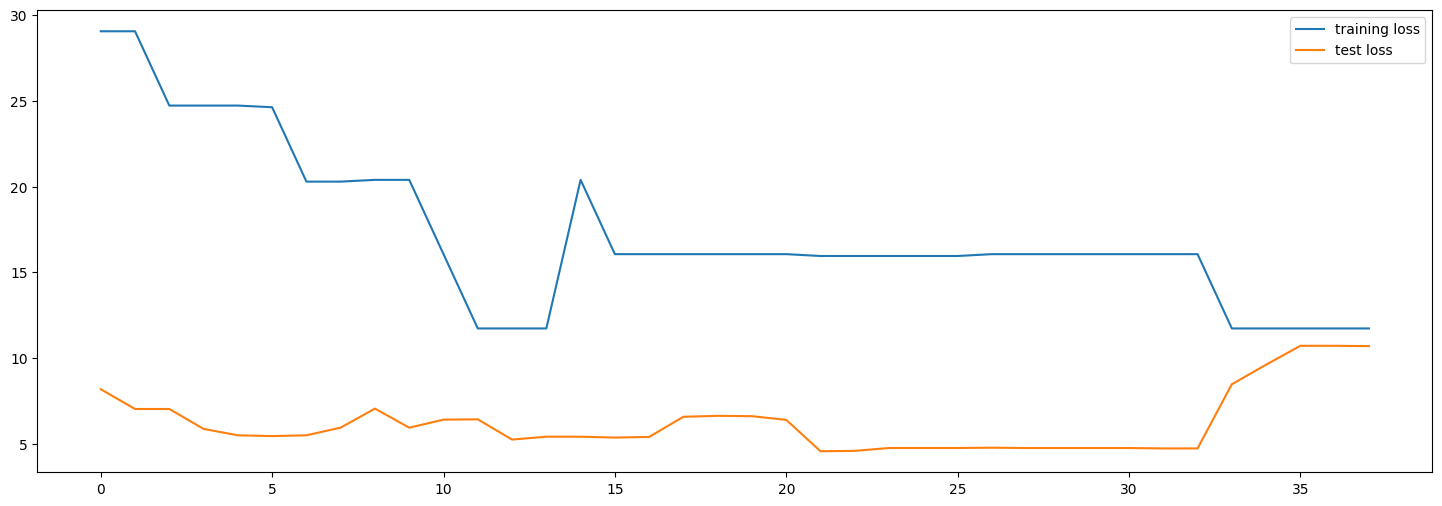

In [6]:
mse, hr_err, hrv_err = mod.eval()

print(f'\n\nMSE: {mse}')
print(f'HR error: {hr_err}')
print(f'HR error squared: {hrv_err}\n\n')

mod.get_model_stats()
mod.plot_hr_loss()

## Plot the predicted signal versus its ground truth

peak memory: 211.04 MiB, increment: 0.05 MiB
Time elapsed: 0:00:00.073025
True HR: 49.10485933503836; Pred HR: 80.84210526315789


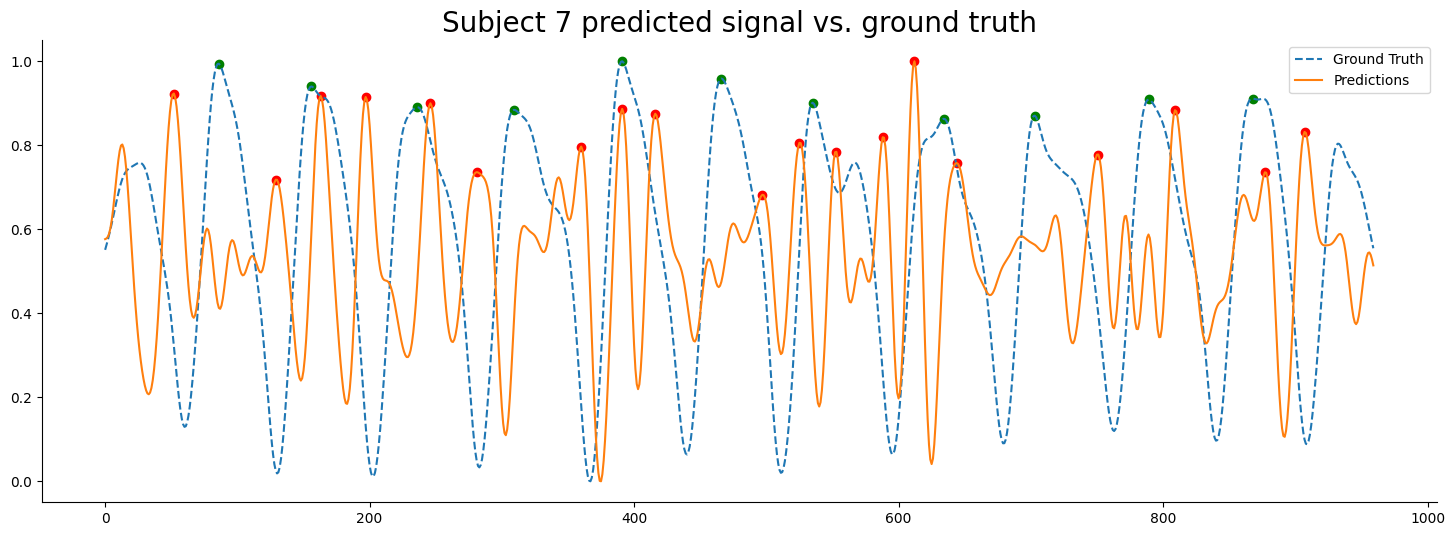

In [7]:
# beginning point from which to plot
beg = 3000
end = beg + 960  # we add 960 bc that's the period which HR error is calculated; it's also the amount of user video needed to calculate HR error (15s)

# prepare test subject data for ML, and give it the corresponding mem feats (8 mem feat, 12 skip amount)
data = test_subject_truth.prepare_data_for_ml(8, 12)

# get input data and target data
X = xgb.DMatrix(data.drop(columns = ['bvp']).to_numpy())
y = data['bvp'].to_numpy()

# get the model predictions in this method so that RAM usage is measured accurately
def measure_code_block():
    t = datetime.today()
    targ = y[beg: end]
    pred = mod.predict(X)
    pred = pred[beg: end]
    targ, pred = mod.process_signal(targ, pred, use_bandpass=True)
    elapsed_time = datetime.today() - t
    return targ, pred, elapsed_time

# measure the RAM usage of the model while also getting the predictions and processing both predictions and targets
%memit targ, pred, elapsed_time = measure_code_block()
print('Time elapsed:', elapsed_time)

# get the predicted and true peaks for each signal
pred_peaks, _ = mod.get_predicted_peaks(pred)
true_peaks, _ = mod.get_true_peaks(targ)

# create the plot
plt.plot(targ, linestyle = '--', label = 'Ground Truth')
plt.plot(pred, label = 'Predictions')
plt.legend()
plt.title(f'Subject {test_subject} predicted signal vs. ground truth', fontsize = 20)

# modify plot appearance
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')

# plot the peaks
plt.scatter(pred_peaks, pred[pred_peaks], c='r')
plt.scatter(true_peaks, targ[true_peaks], c='g')

# compute the predicted and true HR for this block
pred_ibis = np.diff(pred_peaks) / 64
true_ibis = np.diff(true_peaks) / 64
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')

## 4. Apply cross-validation to validate performance

In [11]:
special_truths = {}
for i in range(1, 8):
    special_truths[i] = {
        'training': [truths[i - 1]],
        'testing': [noisy_truths[i - 1], dim_truths[i - 1], bright_truths[i - 1]]
    }

rpm = 5
res = SubjectwiseCrossVal(
    special_truths, random_state = None, loss_type = 'combined', rounds_per_model = rpm,
    n_estimators = 188, split_size = 960, learning_rate = 0.001,
    early_stopping_rounds = 16, mse_weight = 0.2, dtw_weight = 0.8, data_beg = 1000, data_end = 4000,
    batches = 5, min_bandpass_freq = 0.7, max_bandpass_freq = 4.0, bandpass_order = 4,
    predicted_peaks_prominence = 0.28,
    true_peaks_prominence = 0.322741927274642,
    max_depth = 6, max_bin = 235, num_feats_per_channel = 8, skip_amount = 12, collect = True
)

Number of samples in dataset: 17484


On batch 1 of 5:
[0]	train-rmse:0.78103	train-hr_err:24.79148	test-rmse:0.88071	test-hr_err:23.85287
[5]	train-rmse:0.78496	train-hr_err:17.68372	test-rmse:0.88248	test-hr_err:20.99288
[10]	train-rmse:0.78891	train-hr_err:20.40673	test-rmse:0.88428	test-hr_err:19.80270
[15]	train-rmse:0.79288	train-hr_err:20.37497	test-rmse:0.88611	test-hr_err:19.78486
[20]	train-rmse:0.79684	train-hr_err:20.35526	test-rmse:0.88795	test-hr_err:19.32883
[25]	train-rmse:0.80078	train-hr_err:20.35526	test-rmse:0.88985	test-hr_err:20.00596
[30]	train-rmse:0.80474	train-hr_err:20.35526	test-rmse:0.89178	test-hr_err:19.54630
[31]	train-rmse:0.80554	train-hr_err:20.35526	test-rmse:0.89217	test-hr_err:19.54630
Fintuning...
[0]	train-rmse:1.23792	train-hr_err:20.35526	test-rmse:0.89187	test-hr_err:19.54630
[5]	train-rmse:1.23243	train-hr_err:17.24509	test-rmse:0.88845	test-hr_err:18.97688
[10]	train-rmse:1.22697	train-hr_err:16.81965	test-rmse:0.88508	test-hr_err:20.18531
[

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dt

In [18]:
def analyze_res(res):

    means = {
    }

    for subject in res:
        means[subject] = {}

        for mod in res[subject]:
            mod_run = res[subject][mod]

            reg_runs = mod_run[0]
            noisy_runs = mod_run[1]
            dim_runs = mod_run[2]
            bright_runs = mod_run[3]

            reg_means = {
                'mse': (np.nanmean([run['mse'] for run in reg_runs]), np.nanstd([run['mse'] for run in reg_runs])),
                'hr_err': (np.nanmean([run['hr_err'] for run in reg_runs]), np.nanstd([run['hr_err'] for run in reg_runs])),
                'hrv_err': (np.nanmean([run['hrv_err'] for run in reg_runs]), np.nanstd([run['hrv_err'] for run in reg_runs])),
                'peaks_err': (np.nanmean([run['peaks_err'] for run in reg_runs]), np.nanstd([run['peaks_err'] for run in reg_runs]))
            }
            noisy_means = {
                'mse': (np.nanmean([run['mse'] for run in noisy_runs]), np.nanstd([run['mse'] for run in noisy_runs])),
                'hr_err': (np.nanmean([run['hr_err'] for run in noisy_runs]), np.nanstd([run['hr_err'] for run in noisy_runs])),
                'hrv_err': (np.nanmean([run['hrv_err'] for run in noisy_runs]), np.nanstd([run['hrv_err'] for run in noisy_runs])),
                'peaks_err': (np.nanmean([run['peaks_err'] for run in noisy_runs]), np.nanstd([run['peaks_err'] for run in noisy_runs]))
            }
            dim_means = {
                'mse': (np.nanmean([run['mse'] for run in dim_runs]), np.nanstd([run['mse'] for run in dim_runs])),
                'hr_err': (np.nanmean([run['hr_err'] for run in dim_runs]), np.nanstd([run['hr_err'] for run in dim_runs])),
                'hrv_err': (np.nanmean([run['hrv_err'] for run in dim_runs]), np.nanstd([run['hrv_err'] for run in dim_runs])),
                'peaks_err': (np.nanmean([run['peaks_err'] for run in dim_runs]), np.nanstd([run['peaks_err'] for run in dim_runs]))
            }
            bright_means = {
                'mse': (np.nanmean([run['mse'] for run in bright_runs]), np.nanstd([run['mse'] for run in bright_runs])),
                'hr_err': (np.nanmean([run['hr_err'] for run in bright_runs]), np.nanstd([run['hr_err'] for run in bright_runs])),
                'hrv_err': (np.nanmean([run['hrv_err'] for run in bright_runs]), np.nanstd([run['hrv_err'] for run in bright_runs])),
                'peaks_err': (np.nanmean([run['peaks_err'] for run in bright_runs]), np.nanstd([run['peaks_err'] for run in bright_runs]))
            }

            means[subject][mod] = {
                'reg': reg_means,
                'noisy': noisy_means,
                'dim': dim_means,
                'bright': bright_means
            }

    return means

ana = analyze_res(res)

In [24]:
reg_mses = []
reg_hrs = []
reg_hrvs = []
reg_peaks = []
noisy_mses = []
noisy_hrs = []
noisy_hrvs = []
noisy_peaks = []
dim_mses = []
dim_hrs = []
dim_hrvs = []
dim_peaks = []
bright_mses = []
bright_hrs = []
bright_hrvs = []
bright_peaks = []

rlines = []
nlines = []
dlines = []
blines = []

for subject in ana:
    print(f'Subject {subject}:')
    reg = []
    noisy = []
    dim = []
    bright = []

    for mod in ana[subject]:
        reg.append(ana[subject][mod]['reg'])
        noisy.append(ana[subject][mod]['noisy'])
        dim.append(ana[subject][mod]['dim'])
        bright.append(ana[subject][mod]['bright'])
    

    best = 0
    for i, mod in enumerate(reg):
        if mod['hr_err'] < reg[best]['hr_err']:
            best = i
    reg_mse = reg[best]['mse']
    reg_hr = reg[best]['hr_err']
    reg_hrv = reg[best]['hrv_err']
    reg_peak = reg[best]['peaks_err']

    # reg_mse = np.nanmean([mod['mse'] for mod in reg])
    # reg_hr = np.nanmean([mod['hr_err'] for mod in reg])
    # reg_hrv = np.nanmean([mod['hrv_err'] for mod in reg])
    # reg_peak = np.nanmean([mod['peaks_err'] for mod in reg])

    reg_mses.append(reg_mse)
    reg_hrs.append(reg_hr)
    reg_hrvs.append(reg_hrv)
    reg_peaks.append(reg_peak)

    print(f'\tReg MSE: {reg_mse}')
    print(f'\tReg HR: {reg_hr}')
    print(f'\tReg HRV: {reg_hrv}')
    print(f'\tReg Peaks: {reg_peak}')
    line = f'& {subject} & {round(reg_hr[0], 2)} $\pm$ {round(reg_hr[1], 2)} & {round(reg_hrv[0], 2)} $\pm$ {round(reg_hrv[1], 2)} & {round(reg_peak[0], 2)} $\pm$ {round(reg_peak[1], 2)} \\'
    print(f'Line: {line}')
    rlines.append(line)
    print()

    noisy_mse = noisy[best]['mse']
    noisy_hr = noisy[best]['hr_err']
    noisy_hrv = noisy[best]['hrv_err']
    noisy_peak = noisy[best]['peaks_err']

    # noisy_mse = np.nanmean([mod['mse'] for mod in noisy])
    # noisy_hr = np.nanmean([mod['hr_err'] for mod in noisy])
    # noisy_hrv = np.nanmean([mod['hrv_err'] for mod in noisy])
    # noisy_peak = np.nanmean([mod['peaks_err'] for mod in noisy])

    noisy_mses.append(noisy_mse)
    noisy_hrs.append(noisy_hr)
    noisy_hrvs.append(noisy_hrv)
    noisy_peaks.append(noisy_peak)

    print(f'\tNoisy MSE: {noisy_mse}')
    print(f'\tNoisy HR: {noisy_hr}')
    print(f'\tNoisy HRV: {noisy_hrv}')
    print(f'\tNoisy Peaks: {noisy_peak}')
    line = f'& {subject} & {round(noisy_hr[0], 2)} $\pm$ {round(noisy_hr[1], 2)} & {round(noisy_hrv[0], 2)} $\pm$ {round(noisy_hrv[1], 2)} & {round(noisy_peak[0], 2)} $\pm$ {round(noisy_peak[1], 2)} \\'
    print(f'Line: {line}')
    nlines.append(line)
    print()

    dim_mse = dim[best]['mse']
    dim_hr = dim[best]['hr_err']
    dim_hrv = dim[best]['hrv_err']
    dim_peak = dim[best]['peaks_err']

    # dim_mse = np.nanmean([mod['mse'] for mod in dim])
    # dim_hr = np.nanmean([mod['hr_err'] for mod in dim])
    # dim_hrv = np.nanmean([mod['hrv_err'] for mod in dim])
    # dim_peak = np.nanmean([mod['peaks_err'] for mod in dim])

    dim_mses.append(dim_mse)
    dim_hrs.append(dim_hr)
    dim_hrvs.append(dim_hrv)
    dim_peaks.append(dim_peak)

    print(f'\tDim MSE: {dim_mse}')
    print(f'\tDim HR: {dim_hr}')
    print(f'\tDim HRV: {dim_hrv}')
    print(f'\tDim Peaks: {dim_peak}')
    line = f'& {subject} & {round(dim_hr[0], 2)} $\pm$ {round(dim_hr[1], 2)} & {round(dim_hrv[0], 2)} $\pm$ {round(dim_hrv[1], 2)} & {round(dim_peak[0], 2)} $\pm$ {round(dim_peak[1], 2)} \\'
    print(f'Line: {line}')
    dlines.append(line)
    print()

    bright_mse = bright[best]['mse']
    bright_hr = bright[best]['hr_err']
    bright_hrv = bright[best]['hrv_err']
    bright_peak = bright[best]['peaks_err']

    # bright_mse = np.nanmean([mod['mse'] for mod in bright])
    # bright_hr = np.nanmean([mod['hr_err'] for mod in bright])
    # bright_hrv = np.nanmean([mod['hrv_err'] for mod in bright])
    # bright_peak = np.nanmean([mod['peaks_err'] for mod in bright])

    bright_mses.append(bright_mse)
    bright_hrs.append(bright_hr)
    bright_hrvs.append(bright_hrv)
    bright_peaks.append(bright_peak)

    print(f'\tBright MSE: {bright_mse}')
    print(f'\tBright HR: {bright_hr}')
    print(f'\tBright HRV: {bright_hrv}')
    print(f'\tBright Peaks: {bright_peak}')
    line = f'& {subject} & {round(bright_hr[0], 2)} $\pm$ {round(bright_hr[1], 2)} & {round(bright_hrv[0], 2)} $\pm$ {round(bright_hrv[1], 2)} & {round(bright_peak[0], 2)} $\pm$ {round(bright_peak[1], 2)} \\'
    print(f'Line: {line}')
    blines.append(line)
    print()

print(f'Reg MSE: {np.nanmean(reg_mses)}')
print(f'Reg HR: {np.nanmean(reg_hrs)}')
print(f'Reg HRV: {np.nanmean(reg_hrvs)}')
print(f'Reg Peaks: {np.nanmean(reg_peaks)}')
print()
print(f'Noisy MSE: {np.nanmean(noisy_mses)}')
print(f'Noisy HR: {np.nanmean(noisy_hrs)}')
print(f'Noisy HRV: {np.nanmean(noisy_hrvs)}')
print(f'Noisy Peaks: {np.nanmean(noisy_peaks)}')
print()

print(f'Dim MSE: {np.nanmean(dim_mses)}')
print(f'Dim HR: {np.nanmean(dim_hrs)}')
print(f'Dim HRV: {np.nanmean(dim_hrvs)}')
print(f'Dim Peaks: {np.nanmean(dim_peaks)}')
print()

print(f'Bright MSE: {np.nanmean(bright_mses)}')
print(f'Bright HR: {np.nanmean(bright_hrs)}')
print(f'Bright HRV: {np.nanmean(bright_hrvs)}')
print(f'Bright Peaks: {np.nanmean(bright_peaks)}')
print()

print('Reg lines:')
for line in rlines:
    print(line)
print()
print('Noisy lines')
for line in nlines:
    print(line)
print()
print('Dim lines')
for line in dlines:
    print(line)
print()
print('Bright lines')
for line in blines:
    print(line)
print()


Subject 1:
	Reg MSE: (0.09205270254556491, 0.025303761099483266)
	Reg HR: (11.269396480081054, 16.10934136536508)
	Reg HRV: (0.4746465948238992, 0.2959618960439233)
	Reg Peaks: (3.6296296296296298, 4.389787374823423)
Line: & 1 & 11.27 $\pm$ 16.11 & 0.47 $\pm$ 0.3 & 3.63 $\pm$ 4.39 \

	Noisy MSE: (0.08789295952689635, 0.02433836840661998)
	Noisy HR: (19.473769477472313, 19.26853721394194)
	Noisy HRV: (0.9396224729787934, 0.7098555458041064)
	Noisy Peaks: (5.407407407407407, 4.201051537318293)
Line: & 1 & 19.47 $\pm$ 19.27 & 0.94 $\pm$ 0.71 & 5.41 $\pm$ 4.2 \

	Dim MSE: (0.09082130098130468, 0.02482514834948734)
	Dim HR: (26.166508043109555, 26.572326916368088)
	Dim HRV: (1.367933565489334, 1.2301102857094828)
	Dim Peaks: (6.37037037037037, 3.713320847257565)
Line: & 1 & 26.17 $\pm$ 26.57 & 1.37 $\pm$ 1.23 & 6.37 $\pm$ 3.71 \

	Bright MSE: (0.09016683664730983, 0.027474557834111936)
	Bright HR: (30.821851119865627, 19.38376576823381)
	Bright HRV: (1.5488388796194925, 1.244046795002979)
	

In [ ]:
\multirow{7}{*}{None} & 1 & 11.27 $\pm$ 16.12 & 0.47 $\pm$ 0.30 & 3.63 $\pm$ 4.39 \\
    & 2 & 16.61 $\pm$ 9.53 & 0.57 $\pm$ 0.28 & 5.8 $\pm$ 3.27 \\
    & 3 & 21.62 $\pm$ 11.41 & 0.37 $\pm$ 0.08 & 5.4 $\pm$ 2.42 \\
    & 4 & 13.58 $\pm$ 4.7 & 0.46 $\pm$ 0.13 & 3.6 $\pm$ 1.22 \\
    & 5 & 11.62 $\pm$ 6.23 & 0.44 $\pm$ 0.06 & 2.87 $\pm$ 0.86 \\
    & 6 & 23.05 $\pm$ 8.86 & 0.67 $\pm$ 0.27 & 6.2 $\pm$ 2.19 \\
    & 7 & 18.34 $\pm$ 6.98 & 0.45 $\pm$ 0.08 & 4.4 $\pm$ 1.21 \\
    \midrule

In [17]:
ana[1][best]

{'reg': {'mse': 0.09964726754478888,
  'hr_err': 15.970797566538177,
  'hrv_err': 0.4114678253438271,
  'peaks_err': 4.666666666666667},
 'noisy': {'mse': 0.08999376433274431,
  'hr_err': 22.335915914792242,
  'hrv_err': 1.2100367714928677,
  'peaks_err': 6.37037037037037},
 'dim': {'mse': 0.0876332075493613,
  'hr_err': 34.73018403895383,
  'hrv_err': 2.031722845659035,
  'peaks_err': 8.851851851851851},
 'bright': {'mse': 0.08681466103457015,
  'hr_err': 37.9527574709661,
  'hrv_err': 1.529000440868039,
  'peaks_err': 9.703703703703704}}

In [9]:
def analyze_res(res):

    errs = {'mse': [], 'hr_err': [], 'hrv_err': [], 'peaks_err': []}
    for subject in res:

        subres = {'mse': [], 'hr_err': [], 'hrv_err': [], 'peaks_err': []}
        for trial in res[subject]:

            mses = [d['mse'] for d in trial]
            hr_errs = [d['hr_err'] for d in trial]
            hrv_err = [d['hrv_err'] for d in trial]
            peaks_errs = [d['peaks_err'] for d in trial]

            mmse = np.mean(mses)
            mhr_err = np.mean(hr_errs)
            mhrv_err = np.mean(hrv_err)
            mpeaks_err = np.mean(peaks_errs)

            subres['mse'].append(mmse)
            subres['hr_err'].append(mhr_err)
            subres['hrv_err'].append(mhrv_err)
            subres['peaks_err'].append(mpeaks_err)
        
        errs['mse'].append(tuple(subres['mse']))
        errs['hr_err'].append(tuple(subres['hr_err']))
        errs['hrv_err'].append(tuple(subres['hrv_err']))
        errs['peaks_err'].append(tuple(subres['peaks_err']))

        print(f'Subject {subject} MSE: {np.mean(subres["mse"])}')
        print(f'Subject {subject} HR error: {np.mean(subres["hr_err"])}')
        print(f'Subject {subject} HRV error: {np.mean(subres["hrv_err"])}')
        print(f'Subject {subject} Peaks error: {np.mean(subres["peaks_err"])}\n')

    return errs

errs = analyze_res(res)
print(f'Overall HR ERR: {np.mean(errs["hr_err"])}')

Subject 1 MSE: 0.08957351048812277
Subject 1 HR error: 19.10425847545256
Subject 1 HRV error: 0.7247776083169766
Subject 1 Peaks error: 4.833333333333334

Subject 2 MSE: 0.09292266615105475
Subject 2 HR error: 20.942578678567884
Subject 2 HRV error: 0.42398899902796544
Subject 2 Peaks error: 5.966666666666667

Subject 3 MSE: 0.08228378273636769
Subject 3 HR error: 20.377726652483908
Subject 3 HRV error: 0.5903542384529781
Subject 3 Peaks error: 6.1

Subject 4 MSE: 0.08762808504111072
Subject 4 HR error: 17.84802547891082
Subject 4 HRV error: 0.4288066397793143
Subject 4 Peaks error: 5.0

Subject 5 MSE: 0.0882631101651939
Subject 5 HR error: 17.592270732784556
Subject 5 HRV error: 0.6169799218649265
Subject 5 Peaks error: 4.633333333333333

Subject 6 MSE: 0.08522477701298212
Subject 6 HR error: 23.093801545893488
Subject 6 HRV error: 0.5226240949955618
Subject 6 Peaks error: 6.833333333333333

Subject 7 MSE: 0.08678474423807248
Subject 7 HR error: 20.175340287870096
Subject 7 HRV error:

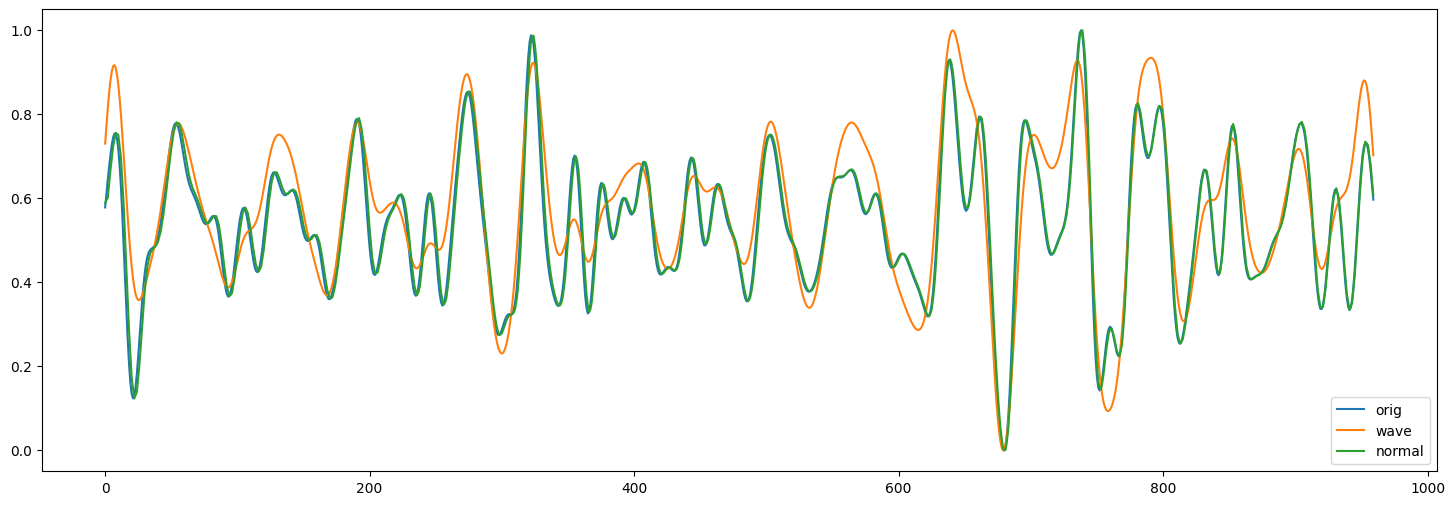

In [19]:
import pywt
from pipeline_v1.wavelet import apply_wavelet
def cwt_morlet_filter(signal, sample_freq=30, f_min=0.67, f_max=4.0, num_steps=200):
    sampling_period = 1.0 / sample_freq

    # Define the wavelet
    wavelet = 'morl'

    # Compute the corresponding scales
    scale_min = pywt.scale2frequency(wavelet, f_min) / sampling_period
    scale_max = pywt.scale2frequency(wavelet, f_max) / sampling_period

    # Create a range of scales
    scales = np.linspace(scale_max, scale_min, num_steps)

    # Compute the CWT
    cwt_coeffs, _ = pywt.cwt(signal, scales, wavelet, sampling_period)

    # Filter the signal
    filtered_signal = np.sum(cwt_coeffs, axis=0)

    return filtered_signal


plt.plot(min_max_scale(pred), label = 'orig')
plt.plot(min_max_scale(cwt_morlet_filter(pred, 64)), label = 'wave')
plt.plot(min_max_scale(apply_wavelet(pred)), label = 'normal')
plt.legend()

## Bayesian hyperparameter optimization demonstration

In [ ]:
optimizer = MoodBoostOptimizer(truths)
result = optimizer.optimize(n_calls = 10)
print(result)